# Model comparisons

In this notebook, we'll take BartPy through its paces using increasingly complex sin wave models.  We'll compare how it performs to two similar models: OLS and catboost.

For the purposes of this exercise, I'm testing out of the box performance.  This makes sense, as part of the value prop of BartPy is it's ability to work well without parameter tuning, but it's possible that the scores of all of the models could be improved with parameter tuning

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import catboost 
from catboost import Pool
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from copy import deepcopy

from bartpy.sklearnmodel import SklearnModel

%matplotlib inline

## Set up models

In [2]:
def fit_catboost(X_train, y_train, X_test, y_test):
    eval_cutoff = len(X_train) // 3
    eval_X, eval_y, train_X, train_y = X_train[:eval_cutoff, :], y_train[:eval_cutoff], X_train[eval_cutoff:, :], y_train[eval_cutoff:]
    catboost_model = catboost.CatBoostRegressor()
    catboost_model.fit(Pool(train_X, train_y), eval_set = Pool(eval_X, eval_y), use_best_model=True)
    pred = catboost_model.predict(X_test)
    score = r2_score(y_test, pred)
    return catboost_model, pred, score

def fit_bartpy(X_train, y_train, X_test, y_test):
    model = SklearnModel(n_samples=1000, n_burn=50, n_trees=500)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    score = model.score(X_test, y_test)
    return model, pred, score

def fit_linear_model(X_train, y_train, X_test, y_test):
    rebased_x = np.sin(X_train[:, 0]).reshape(-1, 1)
    linear_model = LinearRegression()
    linear_model.fit(rebased_x, y_train)
    pred = linear_model.predict(np.sin(X_test[:, 0]).reshape(-1, 1))
    score = linear_model.score(np.sin(X_test[:, 0]).reshape(-1, 1), y_test)
    return linear_model, pred, score

kf = KFold(2)

def compare_models(X, y, models_funcs = [fit_catboost, fit_bartpy, fit_linear_model]):
    scores, predictions, trained_models = [], [], []

    for train_index, test_index in kf.split(X):
        trained_models.append([])    
        scores.append([])
        predictions.append([])

        for f in models_funcs:
            model, pred, score = f(X[train_index, :], y[train_index], X[test_index, :], y[test_index])
            trained_models[-1].append(deepcopy(model))
            predictions[-1].append(pred)
            scores[-1].append(score)
    return scores, predictions, trained_models

## One dimensional, single wave

Text(0.5,1,'X v y')

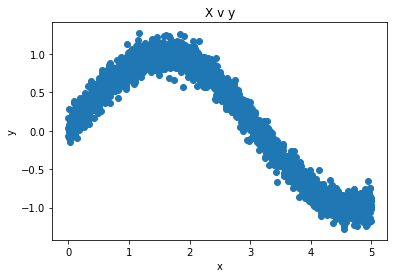

In [21]:
x = np.linspace(0, 5, 3000)
X = pd.DataFrame(x).sample(frac=1.0).values
y = np.random.normal(0, 0.1, size=3000) + np.sin(X[:, 0])
plt.scatter(X[:, 0], y)
plt.xlabel("x")
plt.ylabel("y")
plt.title("X v y")

In [ ]:
scores, predictions, trained_models = compare_models(X, y)

**As we might expect, all three models are capable of capturing such a simple function.  There's very little difference between the scores or predictions of the models.**

In [30]:
scores

[[0.9798728289609591, 0.9779905518639241, 0.9807614189737301],
 [0.9803561997160845, 0.979246487130466, 0.9812808038622604]]

Text(0,0.5,'Predicted Target')

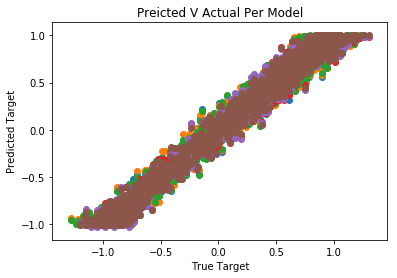

In [31]:
kf = KFold(2)
for p, (train_index, test_index) in zip(predictions, kf.split(X)):
    for m in p:
        plt.scatter(y[test_index], m)
plt.title("Preicted V Actual Per Model")
plt.xlabel("True Target")
plt.ylabel("Predicted Target")

Text(0.5,1,'Prediction by model by value of X')

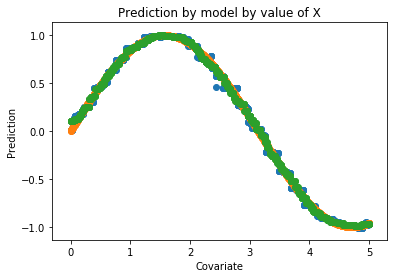

In [28]:
plt.scatter(X[:1500,0],predictions[0][1])
plt.scatter(X[:1500,0],predictions[0][2])
plt.scatter(X[:1500,0],predictions[0][0])
plt.ylabel("Prediction")
plt.xlabel("Covariate")
plt.title("Prediction by model by value of X")

## Single dimension - multiple waves

** To extend our original model, let's add a high frequency cosine wave in our single dimension.  This will make the predicted function change faster and at varying rates across x **

Text(0.5,1,'X v y')

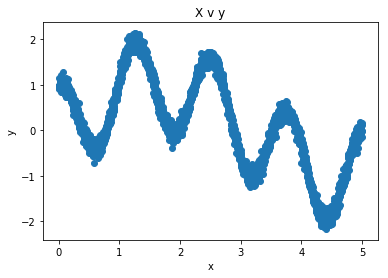

In [23]:
x = np.linspace(0, 5, 3000)
X = pd.DataFrame(x).sample(frac=1.0).values
y = np.random.normal(0, 0.1, size=3000) + np.sin(X[:, 0]) + np.cos(5 * X[:, 0])
plt.scatter(X[:, 0], y)
plt.xlabel("x")
plt.ylabel("y")
plt.title("X v y")

In [ ]:
scores, predictions, trained_models = compare_models(X, y)

** Catboost and BartPy capture this faster moving sin wave pretty nicely, and come up with very similar predictions.  The linear model pretty much treats the cos wave as noise, and fits a curve close to the original one **

In [38]:
scores

[[0.9859508887939317, 0.9754440192208361, 0.48505787845960185],
 [0.9879610023229878, 0.9818666815894833, 0.509902473655678]]

Text(0,0.5,'Predicted Target')

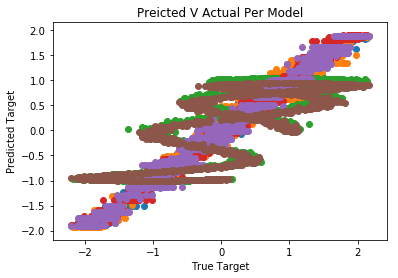

In [39]:
kf = KFold(2)
for p, (train_index, test_index) in zip(predictions, kf.split(X)):
    for m in p:
        plt.scatter(y[test_index], m)
plt.title("Preicted V Actual Per Model")
plt.xlabel("True Target")
plt.ylabel("Predicted Target")

Text(0.5,1,'Prediction by model by value of X')

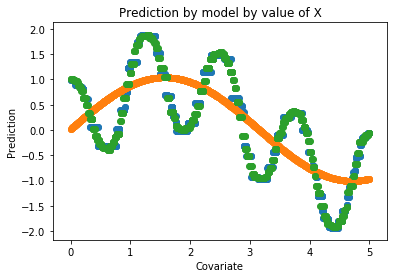

In [40]:
plt.scatter(X[:1500,0],predictions[0][1])
plt.scatter(X[:1500,0],predictions[0][2])
plt.scatter(X[:1500,0],predictions[0][0])
plt.ylabel("Prediction")
plt.xlabel("Covariate")
plt.title("Prediction by model by value of X")

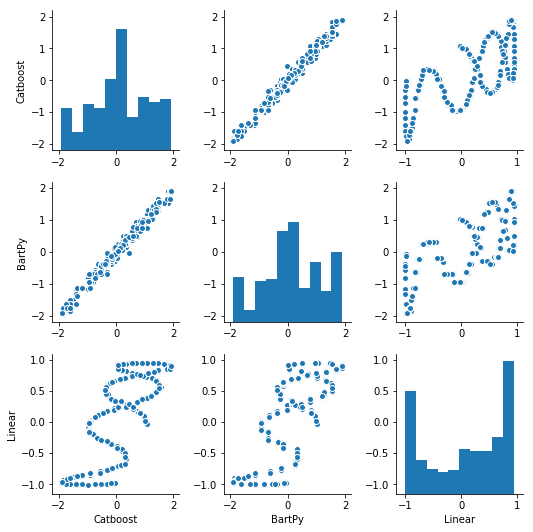

In [41]:
import seaborn as sns
p = pd.DataFrame(np.array(predictions[1]).T, columns = ["Catboost", "BartPy", "Linear"])
sns.pairplot(p)

## Single dimension - discrete break points

** To make the model more complex, let's add some discrete dumps to make the curve less smooth.  This will test the ability of the models to handle very isolated effects in feature space **

Text(0.5,1,'X v y')

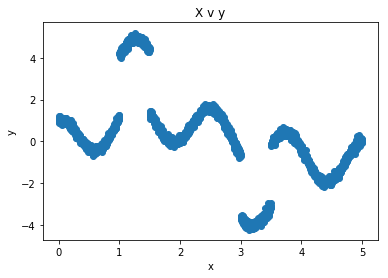

In [49]:
x = np.linspace(0, 5, 3000)
X = pd.DataFrame(x).sample(frac=1.0).values
y = np.random.normal(0, 0.1, size=3000) + np.sin(X[:, 0]) + np.cos(5 * X[:, 0])
y[(X[:,0] < 1.5) & (X[:,0] > 1.)] += 3
y[(X[:,0] < 3.5) & (X[:,0] > 3.)] -= 3
plt.scatter(X[:, 0], y)
plt.xlabel("x")
plt.ylabel("y")
plt.title("X v y")

In [ ]:
scores, predictions, trained_models = compare_models(X, y)

In [52]:
scores

[[0.978236396149402, 0.9885191202572745, 0.2956934596944424],
 [0.9780588821482012, 0.9910936825961947, 0.3214370553664061]]

Text(0,0.5,'Predicted Target')

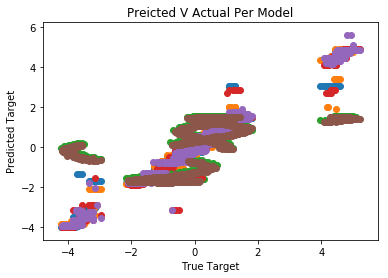

In [51]:
kf = KFold(2)
for p, (train_index, test_index) in zip(predictions, kf.split(X)):
    for m in p:
        plt.scatter(y[test_index], m)
plt.title("Preicted V Actual Per Model")
plt.xlabel("True Target")
plt.ylabel("Predicted Target")

Text(0.5,1,'Prediction by model by value of X')

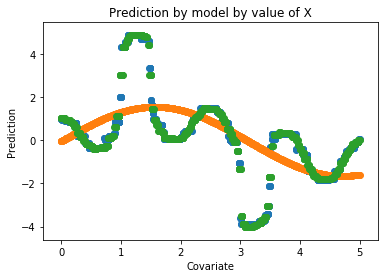

In [53]:
plt.scatter(X[:1500,0],predictions[0][1])
plt.scatter(X[:1500,0],predictions[0][2])
plt.scatter(X[:1500,0],predictions[0][0])
plt.ylabel("Prediction")
plt.xlabel("Covariate")
plt.title("Prediction by model by value of X")

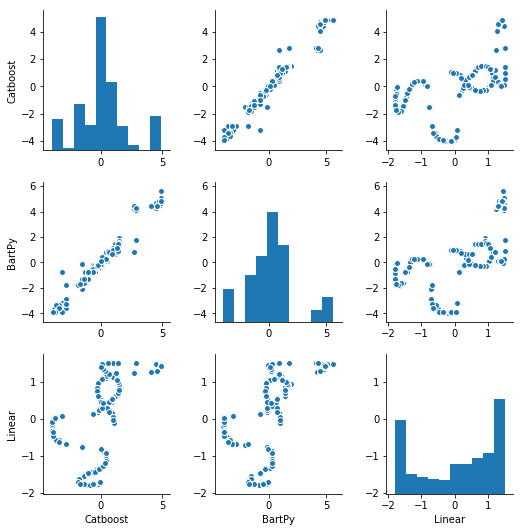

In [54]:
import seaborn as sns
p = pd.DataFrame(np.array(predictions[1]).T, columns = ["Catboost", "BartPy", "Linear"])
sns.pairplot(p)

# Single meaningful dimension - additional noise dimensions

** It's important for the models to be able to correctly identify features that aren't important.  In this case, we just add normally distributed noise features.  This shouldn't be too difficult a problem to solve **

Text(0.5,1,'X v y')

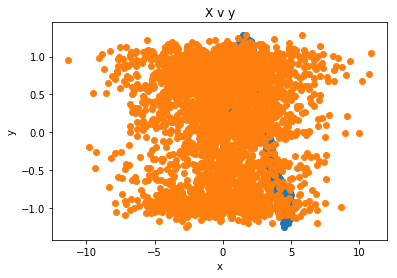

In [3]:
x = np.linspace(0, 5, 3000)
X = np.random.normal(0, 3, size = 3000 * 8).reshape(3000, 8)
X[:, 0] = x
X = pd.DataFrame(X).sample(frac=1.0).values
y = np.random.normal(0, 0.1, size=3000) + np.sin(X[:, 0])
plt.scatter(X[:, 0], y)
plt.scatter(X[:, 1], y)
plt.xlabel("x")
plt.ylabel("y")
plt.title("X v y")

In [ ]:
scores, predictions, trained_models = compare_models(X, y)

0:	learn: 0.7244123	test: 0.7138649	best: 0.7138649 (0)	total: 86ms	remaining: 1m 25s
1:	learn: 0.7061425	test: 0.6960052	best: 0.6960052 (1)	total: 125ms	remaining: 1m 2s
2:	learn: 0.6892175	test: 0.6793304	best: 0.6793304 (2)	total: 171ms	remaining: 56.7s
3:	learn: 0.6719173	test: 0.6624753	best: 0.6624753 (3)	total: 214ms	remaining: 53.3s
4:	learn: 0.6559259	test: 0.6468087	best: 0.6468087 (4)	total: 253ms	remaining: 50.3s
5:	learn: 0.6401903	test: 0.6313601	best: 0.6313601 (5)	total: 293ms	remaining: 48.5s
6:	learn: 0.6262180	test: 0.6176949	best: 0.6176949 (6)	total: 333ms	remaining: 47.2s
7:	learn: 0.6120278	test: 0.6037719	best: 0.6037719 (7)	total: 370ms	remaining: 45.8s
8:	learn: 0.5965734	test: 0.5887769	best: 0.5887769 (8)	total: 409ms	remaining: 45s
9:	learn: 0.5812505	test: 0.5736124	best: 0.5736124 (9)	total: 446ms	remaining: 44.2s
10:	learn: 0.5665265	test: 0.5592137	best: 0.5592137 (10)	total: 484ms	remaining: 43.5s
11:	learn: 0.5537227	test: 0.5468829	best: 0.5468829 (

94:	learn: 0.1279663	test: 0.1361984	best: 0.1361984 (94)	total: 3.92s	remaining: 37.4s
95:	learn: 0.1268082	test: 0.1350529	best: 0.1350529 (95)	total: 3.97s	remaining: 37.4s
96:	learn: 0.1258310	test: 0.1341251	best: 0.1341251 (96)	total: 4.02s	remaining: 37.4s
97:	learn: 0.1248923	test: 0.1332659	best: 0.1332659 (97)	total: 4.07s	remaining: 37.5s
98:	learn: 0.1240784	test: 0.1324969	best: 0.1324969 (98)	total: 4.12s	remaining: 37.5s
99:	learn: 0.1236666	test: 0.1322208	best: 0.1322208 (99)	total: 4.18s	remaining: 37.6s
100:	learn: 0.1229871	test: 0.1315861	best: 0.1315861 (100)	total: 4.23s	remaining: 37.6s
101:	learn: 0.1220693	test: 0.1307080	best: 0.1307080 (101)	total: 4.27s	remaining: 37.6s
102:	learn: 0.1212757	test: 0.1299886	best: 0.1299886 (102)	total: 4.33s	remaining: 37.7s
103:	learn: 0.1205361	test: 0.1293377	best: 0.1293377 (103)	total: 4.38s	remaining: 37.7s
104:	learn: 0.1195403	test: 0.1283867	best: 0.1283867 (104)	total: 4.43s	remaining: 37.8s
105:	learn: 0.1189014	

186:	learn: 0.1008216	test: 0.1120575	best: 0.1120575 (186)	total: 7.79s	remaining: 33.9s
187:	learn: 0.1007859	test: 0.1120351	best: 0.1120351 (187)	total: 7.84s	remaining: 33.9s
188:	learn: 0.1007856	test: 0.1120355	best: 0.1120351 (187)	total: 7.86s	remaining: 33.7s
189:	learn: 0.1007064	test: 0.1119880	best: 0.1119880 (189)	total: 7.91s	remaining: 33.7s
190:	learn: 0.1005509	test: 0.1118344	best: 0.1118344 (190)	total: 7.95s	remaining: 33.7s
191:	learn: 0.1005409	test: 0.1118418	best: 0.1118344 (190)	total: 8s	remaining: 33.6s
192:	learn: 0.1004829	test: 0.1117824	best: 0.1117824 (192)	total: 8.06s	remaining: 33.7s
193:	learn: 0.1004756	test: 0.1117869	best: 0.1117824 (192)	total: 8.11s	remaining: 33.7s
194:	learn: 0.1002759	test: 0.1116381	best: 0.1116381 (194)	total: 8.16s	remaining: 33.7s
195:	learn: 0.1002661	test: 0.1116455	best: 0.1116381 (194)	total: 8.19s	remaining: 33.6s
196:	learn: 0.1002276	test: 0.1116350	best: 0.1116350 (196)	total: 8.24s	remaining: 33.6s
197:	learn: 0

278:	learn: 0.0974286	test: 0.1098668	best: 0.1098668 (278)	total: 11.4s	remaining: 29.4s
279:	learn: 0.0974251	test: 0.1098665	best: 0.1098665 (279)	total: 11.4s	remaining: 29.3s
280:	learn: 0.0973972	test: 0.1098598	best: 0.1098598 (280)	total: 11.4s	remaining: 29.3s
281:	learn: 0.0972981	test: 0.1097770	best: 0.1097770 (281)	total: 11.5s	remaining: 29.2s
282:	learn: 0.0971991	test: 0.1097035	best: 0.1097035 (282)	total: 11.5s	remaining: 29.2s
283:	learn: 0.0971712	test: 0.1096842	best: 0.1096842 (283)	total: 11.6s	remaining: 29.2s
284:	learn: 0.0971690	test: 0.1096842	best: 0.1096842 (283)	total: 11.6s	remaining: 29.1s
285:	learn: 0.0971015	test: 0.1096472	best: 0.1096472 (285)	total: 11.6s	remaining: 29.1s
286:	learn: 0.0970874	test: 0.1096441	best: 0.1096441 (286)	total: 11.7s	remaining: 29.1s
287:	learn: 0.0970852	test: 0.1096431	best: 0.1096431 (287)	total: 11.7s	remaining: 29s
288:	learn: 0.0970841	test: 0.1096450	best: 0.1096431 (287)	total: 11.8s	remaining: 29s
289:	learn: 0.

370:	learn: 0.0956139	test: 0.1089242	best: 0.1089242 (370)	total: 14.3s	remaining: 24.2s
371:	learn: 0.0955824	test: 0.1089450	best: 0.1089242 (370)	total: 14.3s	remaining: 24.1s
372:	learn: 0.0955670	test: 0.1089262	best: 0.1089242 (370)	total: 14.3s	remaining: 24.1s
373:	learn: 0.0955405	test: 0.1089222	best: 0.1089222 (373)	total: 14.4s	remaining: 24.1s
374:	learn: 0.0955325	test: 0.1089225	best: 0.1089222 (373)	total: 14.4s	remaining: 24s
375:	learn: 0.0955271	test: 0.1089174	best: 0.1089174 (375)	total: 14.4s	remaining: 24s
376:	learn: 0.0955263	test: 0.1089168	best: 0.1089168 (376)	total: 14.5s	remaining: 23.9s
377:	learn: 0.0955256	test: 0.1089161	best: 0.1089161 (377)	total: 14.5s	remaining: 23.9s
378:	learn: 0.0955247	test: 0.1089163	best: 0.1089161 (377)	total: 14.5s	remaining: 23.8s
379:	learn: 0.0955226	test: 0.1089132	best: 0.1089132 (379)	total: 14.6s	remaining: 23.8s
380:	learn: 0.0955220	test: 0.1089130	best: 0.1089130 (380)	total: 14.6s	remaining: 23.7s
381:	learn: 0.

462:	learn: 0.0943305	test: 0.1086464	best: 0.1086443 (455)	total: 17.1s	remaining: 19.8s
463:	learn: 0.0943305	test: 0.1086465	best: 0.1086443 (455)	total: 17.1s	remaining: 19.7s
464:	learn: 0.0942771	test: 0.1086095	best: 0.1086095 (464)	total: 17.1s	remaining: 19.7s
465:	learn: 0.0941479	test: 0.1086037	best: 0.1086037 (465)	total: 17.2s	remaining: 19.7s
466:	learn: 0.0941181	test: 0.1086066	best: 0.1086037 (465)	total: 17.2s	remaining: 19.6s
467:	learn: 0.0940977	test: 0.1086091	best: 0.1086037 (465)	total: 17.3s	remaining: 19.6s
468:	learn: 0.0940398	test: 0.1086055	best: 0.1086037 (465)	total: 17.3s	remaining: 19.6s
469:	learn: 0.0940392	test: 0.1086047	best: 0.1086037 (465)	total: 17.3s	remaining: 19.5s
470:	learn: 0.0940392	test: 0.1086053	best: 0.1086037 (465)	total: 17.3s	remaining: 19.5s
471:	learn: 0.0939249	test: 0.1086161	best: 0.1086037 (465)	total: 17.4s	remaining: 19.4s
472:	learn: 0.0939056	test: 0.1086216	best: 0.1086037 (465)	total: 17.4s	remaining: 19.4s
473:	learn

554:	learn: 0.0924135	test: 0.1084810	best: 0.1084681 (543)	total: 20.3s	remaining: 16.3s
555:	learn: 0.0924011	test: 0.1084850	best: 0.1084681 (543)	total: 20.3s	remaining: 16.2s
556:	learn: 0.0923055	test: 0.1085350	best: 0.1084681 (543)	total: 20.4s	remaining: 16.2s
557:	learn: 0.0922965	test: 0.1085340	best: 0.1084681 (543)	total: 20.4s	remaining: 16.2s
558:	learn: 0.0922526	test: 0.1085304	best: 0.1084681 (543)	total: 20.5s	remaining: 16.1s
559:	learn: 0.0921970	test: 0.1085276	best: 0.1084681 (543)	total: 20.5s	remaining: 16.1s
560:	learn: 0.0921167	test: 0.1085094	best: 0.1084681 (543)	total: 20.6s	remaining: 16.1s
561:	learn: 0.0921108	test: 0.1085072	best: 0.1084681 (543)	total: 20.6s	remaining: 16.1s
562:	learn: 0.0920912	test: 0.1085109	best: 0.1084681 (543)	total: 20.7s	remaining: 16.1s
563:	learn: 0.0920769	test: 0.1085151	best: 0.1084681 (543)	total: 20.7s	remaining: 16s
564:	learn: 0.0920712	test: 0.1085137	best: 0.1084681 (543)	total: 20.8s	remaining: 16s
565:	learn: 0.

646:	learn: 0.0896215	test: 0.1087251	best: 0.1084442 (585)	total: 24s	remaining: 13.1s
647:	learn: 0.0896120	test: 0.1087243	best: 0.1084442 (585)	total: 24.1s	remaining: 13.1s
648:	learn: 0.0896039	test: 0.1087355	best: 0.1084442 (585)	total: 24.1s	remaining: 13.1s
649:	learn: 0.0895957	test: 0.1087344	best: 0.1084442 (585)	total: 24.2s	remaining: 13s
650:	learn: 0.0895676	test: 0.1087341	best: 0.1084442 (585)	total: 24.2s	remaining: 13s
651:	learn: 0.0895602	test: 0.1087324	best: 0.1084442 (585)	total: 24.2s	remaining: 12.9s
652:	learn: 0.0895137	test: 0.1087599	best: 0.1084442 (585)	total: 24.3s	remaining: 12.9s
653:	learn: 0.0894671	test: 0.1087816	best: 0.1084442 (585)	total: 24.3s	remaining: 12.9s
654:	learn: 0.0894567	test: 0.1087798	best: 0.1084442 (585)	total: 24.4s	remaining: 12.8s
655:	learn: 0.0894313	test: 0.1087890	best: 0.1084442 (585)	total: 24.4s	remaining: 12.8s
656:	learn: 0.0894233	test: 0.1087940	best: 0.1084442 (585)	total: 24.4s	remaining: 12.8s
657:	learn: 0.08

738:	learn: 0.0875204	test: 0.1090553	best: 0.1084442 (585)	total: 27.5s	remaining: 9.7s
739:	learn: 0.0875131	test: 0.1090533	best: 0.1084442 (585)	total: 27.5s	remaining: 9.67s
740:	learn: 0.0875084	test: 0.1090548	best: 0.1084442 (585)	total: 27.6s	remaining: 9.63s
741:	learn: 0.0874884	test: 0.1090684	best: 0.1084442 (585)	total: 27.6s	remaining: 9.6s
742:	learn: 0.0874768	test: 0.1090703	best: 0.1084442 (585)	total: 27.6s	remaining: 9.56s
743:	learn: 0.0874301	test: 0.1090724	best: 0.1084442 (585)	total: 27.7s	remaining: 9.52s
744:	learn: 0.0874274	test: 0.1090742	best: 0.1084442 (585)	total: 27.7s	remaining: 9.48s
745:	learn: 0.0873929	test: 0.1090754	best: 0.1084442 (585)	total: 27.7s	remaining: 9.45s
746:	learn: 0.0873497	test: 0.1090703	best: 0.1084442 (585)	total: 27.8s	remaining: 9.41s
747:	learn: 0.0872962	test: 0.1090629	best: 0.1084442 (585)	total: 27.8s	remaining: 9.38s
748:	learn: 0.0872954	test: 0.1090658	best: 0.1084442 (585)	total: 27.9s	remaining: 9.33s
749:	learn: 

830:	learn: 0.0857326	test: 0.1093407	best: 0.1084442 (585)	total: 30.9s	remaining: 6.28s
831:	learn: 0.0857325	test: 0.1093419	best: 0.1084442 (585)	total: 30.9s	remaining: 6.23s
832:	learn: 0.0857270	test: 0.1093457	best: 0.1084442 (585)	total: 30.9s	remaining: 6.2s
833:	learn: 0.0857212	test: 0.1093462	best: 0.1084442 (585)	total: 31s	remaining: 6.16s
834:	learn: 0.0856783	test: 0.1093459	best: 0.1084442 (585)	total: 31s	remaining: 6.12s
835:	learn: 0.0856439	test: 0.1093561	best: 0.1084442 (585)	total: 31s	remaining: 6.09s
836:	learn: 0.0856429	test: 0.1093590	best: 0.1084442 (585)	total: 31.1s	remaining: 6.05s
837:	learn: 0.0856397	test: 0.1093649	best: 0.1084442 (585)	total: 31.1s	remaining: 6.01s
838:	learn: 0.0855701	test: 0.1093953	best: 0.1084442 (585)	total: 31.1s	remaining: 5.97s
839:	learn: 0.0855653	test: 0.1093994	best: 0.1084442 (585)	total: 31.2s	remaining: 5.94s
840:	learn: 0.0855606	test: 0.1093977	best: 0.1084442 (585)	total: 31.2s	remaining: 5.9s
841:	learn: 0.0855

922:	learn: 0.0840594	test: 0.1097228	best: 0.1084442 (585)	total: 34.3s	remaining: 2.86s
923:	learn: 0.0840498	test: 0.1097104	best: 0.1084442 (585)	total: 34.4s	remaining: 2.83s
924:	learn: 0.0840493	test: 0.1097127	best: 0.1084442 (585)	total: 34.4s	remaining: 2.79s
925:	learn: 0.0840461	test: 0.1097089	best: 0.1084442 (585)	total: 34.4s	remaining: 2.75s
926:	learn: 0.0840291	test: 0.1097094	best: 0.1084442 (585)	total: 34.5s	remaining: 2.71s
927:	learn: 0.0840199	test: 0.1097115	best: 0.1084442 (585)	total: 34.5s	remaining: 2.68s
928:	learn: 0.0840162	test: 0.1097125	best: 0.1084442 (585)	total: 34.6s	remaining: 2.64s
929:	learn: 0.0839260	test: 0.1097413	best: 0.1084442 (585)	total: 34.6s	remaining: 2.6s
930:	learn: 0.0839227	test: 0.1097426	best: 0.1084442 (585)	total: 34.7s	remaining: 2.57s
931:	learn: 0.0839082	test: 0.1097475	best: 0.1084442 (585)	total: 34.7s	remaining: 2.53s
932:	learn: 0.0839018	test: 0.1097506	best: 0.1084442 (585)	total: 34.7s	remaining: 2.49s
933:	learn:

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:14<00:00,  3.39it/s]


Starting sampling


  6%|█████▊                                                                                                   | 55/1000 [00:17<05:09,  3.06it/s]

In [ ]:
scores

In [ ]:
kf = KFold(2)
for p, (train_index, test_index) in zip(predictions, kf.split(X)):
    for m in p:
        plt.scatter(y[test_index], m)
plt.title("Preicted V Actual Per Model")
plt.xlabel("True Target")
plt.ylabel("Predicted Target")

In [ ]:
plt.scatter(X[:1500,0],predictions[0][1])
plt.scatter(X[:1500,0],predictions[0][2])
plt.scatter(X[:1500,0],predictions[0][0])
plt.ylabel("Prediction")
plt.xlabel("Covariate")
plt.title("Prediction by model by value of X")

In [ ]:
import seaborn as sns
p = pd.DataFrame(np.array(predictions[1]).T, columns = ["Catboost", "BartPy", "Linear"])
sns.pairplot(p)

## Mixture of multiple meaningful dimensions and noise dimensions

** Both catboost and BartPy have performed well with noise dimensions and rapidly moving targets, let's combine them to make a relatively difficult test for tree models **

Text(0.5,1,'X v y')

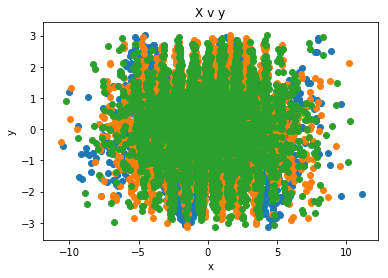

In [4]:
X = np.random.normal(0, 3, size = 3000 * 8).reshape(3000, 8)
X = pd.DataFrame(X).sample(frac=1.0).values
y = np.random.normal(0, 0.1, size=3000) + np.sin(X[:, 0]) + np.sin(5 * X[:, 1]) + np.cos(-6 * X[:, 3])
plt.scatter(X[:, 0], y)
plt.scatter(X[:, 1], y)
plt.scatter(X[:, 3], y)

plt.xlabel("x")
plt.ylabel("y")
plt.title("X v y")


In [5]:
scores, predictions, trained_models = compare_models(X, y)

0:	learn: 1.2237357	test: 1.2045236	best: 1.2045236 (0)	total: 86.5ms	remaining: 1m 26s
1:	learn: 1.2142627	test: 1.1963235	best: 1.1963235 (1)	total: 120ms	remaining: 59.7s
2:	learn: 1.2056820	test: 1.1886719	best: 1.1886719 (2)	total: 161ms	remaining: 53.5s
3:	learn: 1.1974189	test: 1.1817358	best: 1.1817358 (3)	total: 210ms	remaining: 52.3s
4:	learn: 1.1883036	test: 1.1744238	best: 1.1744238 (4)	total: 249ms	remaining: 49.5s
5:	learn: 1.1795971	test: 1.1670184	best: 1.1670184 (5)	total: 289ms	remaining: 47.9s
6:	learn: 1.1717545	test: 1.1604963	best: 1.1604963 (6)	total: 329ms	remaining: 46.6s
7:	learn: 1.1644239	test: 1.1539525	best: 1.1539525 (7)	total: 370ms	remaining: 45.9s
8:	learn: 1.1580788	test: 1.1489298	best: 1.1489298 (8)	total: 416ms	remaining: 45.8s
9:	learn: 1.1505901	test: 1.1429017	best: 1.1429017 (9)	total: 461ms	remaining: 45.6s
10:	learn: 1.1440619	test: 1.1377935	best: 1.1377935 (10)	total: 508ms	remaining: 45.7s
11:	learn: 1.1383013	test: 1.1330045	best: 1.13300

94:	learn: 0.9458414	test: 1.0179651	best: 1.0179651 (94)	total: 4.29s	remaining: 40.9s
95:	learn: 0.9448085	test: 1.0174271	best: 1.0174271 (95)	total: 4.34s	remaining: 40.9s
96:	learn: 0.9436831	test: 1.0170548	best: 1.0170548 (96)	total: 4.38s	remaining: 40.8s
97:	learn: 0.9422353	test: 1.0162299	best: 1.0162299 (97)	total: 4.43s	remaining: 40.8s
98:	learn: 0.9413615	test: 1.0158125	best: 1.0158125 (98)	total: 4.47s	remaining: 40.7s
99:	learn: 0.9392108	test: 1.0147003	best: 1.0147003 (99)	total: 4.51s	remaining: 40.6s
100:	learn: 0.9382410	test: 1.0140692	best: 1.0140692 (100)	total: 4.56s	remaining: 40.6s
101:	learn: 0.9373998	test: 1.0142617	best: 1.0140692 (100)	total: 4.59s	remaining: 40.5s
102:	learn: 0.9365792	test: 1.0143622	best: 1.0140692 (100)	total: 4.64s	remaining: 40.4s
103:	learn: 0.9356497	test: 1.0140772	best: 1.0140692 (100)	total: 4.69s	remaining: 40.4s
104:	learn: 0.9352696	test: 1.0138824	best: 1.0138824 (104)	total: 4.74s	remaining: 40.4s
105:	learn: 0.9327259	

186:	learn: 0.8549963	test: 0.9799841	best: 0.9799841 (186)	total: 8.69s	remaining: 37.8s
187:	learn: 0.8542776	test: 0.9800901	best: 0.9799841 (186)	total: 8.74s	remaining: 37.7s
188:	learn: 0.8538731	test: 0.9798251	best: 0.9798251 (188)	total: 8.78s	remaining: 37.7s
189:	learn: 0.8525569	test: 0.9791336	best: 0.9791336 (189)	total: 8.82s	remaining: 37.6s
190:	learn: 0.8520686	test: 0.9788891	best: 0.9788891 (190)	total: 8.88s	remaining: 37.6s
191:	learn: 0.8512714	test: 0.9785805	best: 0.9785805 (191)	total: 8.92s	remaining: 37.5s
192:	learn: 0.8494046	test: 0.9764094	best: 0.9764094 (192)	total: 8.97s	remaining: 37.5s
193:	learn: 0.8489080	test: 0.9765358	best: 0.9764094 (192)	total: 9.02s	remaining: 37.5s
194:	learn: 0.8475920	test: 0.9753681	best: 0.9753681 (194)	total: 9.07s	remaining: 37.4s
195:	learn: 0.8470923	test: 0.9751646	best: 0.9751646 (195)	total: 9.11s	remaining: 37.4s
196:	learn: 0.8461506	test: 0.9746928	best: 0.9746928 (196)	total: 9.16s	remaining: 37.3s
197:	learn

278:	learn: 0.7732658	test: 0.9295838	best: 0.9295838 (278)	total: 12.5s	remaining: 32.2s
279:	learn: 0.7729913	test: 0.9295645	best: 0.9295645 (279)	total: 12.5s	remaining: 32.2s
280:	learn: 0.7719324	test: 0.9287790	best: 0.9287790 (280)	total: 12.5s	remaining: 32.1s
281:	learn: 0.7715017	test: 0.9285959	best: 0.9285959 (281)	total: 12.6s	remaining: 32s
282:	learn: 0.7712391	test: 0.9285495	best: 0.9285495 (282)	total: 12.6s	remaining: 32s
283:	learn: 0.7702264	test: 0.9276243	best: 0.9276243 (283)	total: 12.7s	remaining: 31.9s
284:	learn: 0.7699621	test: 0.9275856	best: 0.9275856 (284)	total: 12.7s	remaining: 31.8s
285:	learn: 0.7679367	test: 0.9261399	best: 0.9261399 (285)	total: 12.7s	remaining: 31.8s
286:	learn: 0.7657740	test: 0.9242387	best: 0.9242387 (286)	total: 12.8s	remaining: 31.7s
287:	learn: 0.7635184	test: 0.9221867	best: 0.9221867 (287)	total: 12.8s	remaining: 31.7s
288:	learn: 0.7632460	test: 0.9221632	best: 0.9221632 (288)	total: 12.9s	remaining: 31.7s
289:	learn: 0.

370:	learn: 0.6982120	test: 0.8775720	best: 0.8775720 (370)	total: 16.5s	remaining: 28s
371:	learn: 0.6979084	test: 0.8774183	best: 0.8774183 (371)	total: 16.6s	remaining: 28s
372:	learn: 0.6959381	test: 0.8754741	best: 0.8754741 (372)	total: 16.6s	remaining: 27.9s
373:	learn: 0.6936676	test: 0.8743512	best: 0.8743512 (373)	total: 16.7s	remaining: 27.9s
374:	learn: 0.6933222	test: 0.8741994	best: 0.8741994 (374)	total: 16.7s	remaining: 27.8s
375:	learn: 0.6928157	test: 0.8741381	best: 0.8741381 (375)	total: 16.7s	remaining: 27.8s
376:	learn: 0.6904732	test: 0.8720399	best: 0.8720399 (376)	total: 16.8s	remaining: 27.7s
377:	learn: 0.6904149	test: 0.8720477	best: 0.8720399 (376)	total: 16.8s	remaining: 27.7s
378:	learn: 0.6892700	test: 0.8716434	best: 0.8716434 (378)	total: 16.9s	remaining: 27.6s
379:	learn: 0.6890979	test: 0.8716721	best: 0.8716434 (378)	total: 16.9s	remaining: 27.6s
380:	learn: 0.6888483	test: 0.8714312	best: 0.8714312 (380)	total: 16.9s	remaining: 27.5s
381:	learn: 0.

462:	learn: 0.6296151	test: 0.8293340	best: 0.8293340 (462)	total: 20.8s	remaining: 24.2s
463:	learn: 0.6289814	test: 0.8288007	best: 0.8288007 (463)	total: 20.9s	remaining: 24.1s
464:	learn: 0.6284953	test: 0.8283375	best: 0.8283375 (464)	total: 20.9s	remaining: 24.1s
465:	learn: 0.6283757	test: 0.8283794	best: 0.8283375 (464)	total: 20.9s	remaining: 24s
466:	learn: 0.6280054	test: 0.8282508	best: 0.8282508 (466)	total: 21s	remaining: 23.9s
467:	learn: 0.6277333	test: 0.8281280	best: 0.8281280 (467)	total: 21s	remaining: 23.9s
468:	learn: 0.6268511	test: 0.8275281	best: 0.8275281 (468)	total: 21.1s	remaining: 23.8s
469:	learn: 0.6266742	test: 0.8274215	best: 0.8274215 (469)	total: 21.1s	remaining: 23.8s
470:	learn: 0.6266355	test: 0.8274428	best: 0.8274215 (469)	total: 21.1s	remaining: 23.7s
471:	learn: 0.6264402	test: 0.8274819	best: 0.8274215 (469)	total: 21.2s	remaining: 23.7s
472:	learn: 0.6250047	test: 0.8258064	best: 0.8258064 (472)	total: 21.2s	remaining: 23.7s
473:	learn: 0.62

554:	learn: 0.5907273	test: 0.8031676	best: 0.8031676 (554)	total: 24.6s	remaining: 19.7s
555:	learn: 0.5903959	test: 0.8032204	best: 0.8031676 (554)	total: 24.6s	remaining: 19.7s
556:	learn: 0.5894357	test: 0.8021989	best: 0.8021989 (556)	total: 24.6s	remaining: 19.6s
557:	learn: 0.5890408	test: 0.8018009	best: 0.8018009 (557)	total: 24.7s	remaining: 19.6s
558:	learn: 0.5879114	test: 0.8006641	best: 0.8006641 (558)	total: 24.7s	remaining: 19.5s
559:	learn: 0.5878085	test: 0.8005312	best: 0.8005312 (559)	total: 24.8s	remaining: 19.4s
560:	learn: 0.5877641	test: 0.8005747	best: 0.8005312 (559)	total: 24.8s	remaining: 19.4s
561:	learn: 0.5877176	test: 0.8005986	best: 0.8005312 (559)	total: 24.8s	remaining: 19.4s
562:	learn: 0.5875733	test: 0.8005636	best: 0.8005312 (559)	total: 24.9s	remaining: 19.3s
563:	learn: 0.5863069	test: 0.7998068	best: 0.7998068 (563)	total: 24.9s	remaining: 19.3s
564:	learn: 0.5861349	test: 0.7998946	best: 0.7998068 (563)	total: 24.9s	remaining: 19.2s
565:	learn

646:	learn: 0.5609196	test: 0.7818057	best: 0.7817916 (644)	total: 27.9s	remaining: 15.2s
647:	learn: 0.5604061	test: 0.7814189	best: 0.7814189 (647)	total: 28s	remaining: 15.2s
648:	learn: 0.5603438	test: 0.7813652	best: 0.7813652 (648)	total: 28s	remaining: 15.1s
649:	learn: 0.5601629	test: 0.7811549	best: 0.7811549 (649)	total: 28.1s	remaining: 15.1s
650:	learn: 0.5600981	test: 0.7811736	best: 0.7811549 (649)	total: 28.1s	remaining: 15.1s
651:	learn: 0.5600721	test: 0.7811619	best: 0.7811549 (649)	total: 28.2s	remaining: 15s
652:	learn: 0.5600159	test: 0.7811319	best: 0.7811319 (652)	total: 28.2s	remaining: 15s
653:	learn: 0.5599307	test: 0.7810911	best: 0.7810911 (653)	total: 28.3s	remaining: 15s
654:	learn: 0.5598304	test: 0.7810811	best: 0.7810811 (654)	total: 28.3s	remaining: 14.9s
655:	learn: 0.5597762	test: 0.7810902	best: 0.7810811 (654)	total: 28.4s	remaining: 14.9s
656:	learn: 0.5597475	test: 0.7811091	best: 0.7810811 (654)	total: 28.4s	remaining: 14.8s
657:	learn: 0.559736

738:	learn: 0.5343731	test: 0.7652273	best: 0.7652273 (738)	total: 32.2s	remaining: 11.4s
739:	learn: 0.5333030	test: 0.7641725	best: 0.7641725 (739)	total: 32.3s	remaining: 11.3s
740:	learn: 0.5332302	test: 0.7642203	best: 0.7641725 (739)	total: 32.3s	remaining: 11.3s
741:	learn: 0.5331879	test: 0.7641999	best: 0.7641725 (739)	total: 32.3s	remaining: 11.2s
742:	learn: 0.5327898	test: 0.7638753	best: 0.7638753 (742)	total: 32.4s	remaining: 11.2s
743:	learn: 0.5326628	test: 0.7639033	best: 0.7638753 (742)	total: 32.4s	remaining: 11.2s
744:	learn: 0.5316612	test: 0.7628381	best: 0.7628381 (744)	total: 32.5s	remaining: 11.1s
745:	learn: 0.5315559	test: 0.7628589	best: 0.7628381 (744)	total: 32.5s	remaining: 11.1s
746:	learn: 0.5307140	test: 0.7621415	best: 0.7621415 (746)	total: 32.6s	remaining: 11s
747:	learn: 0.5296803	test: 0.7614491	best: 0.7614491 (747)	total: 32.6s	remaining: 11s
748:	learn: 0.5295218	test: 0.7613811	best: 0.7613811 (748)	total: 32.6s	remaining: 10.9s
749:	learn: 0.

830:	learn: 0.5089975	test: 0.7462451	best: 0.7462451 (830)	total: 36.7s	remaining: 7.47s
831:	learn: 0.5089787	test: 0.7462453	best: 0.7462451 (830)	total: 36.8s	remaining: 7.42s
832:	learn: 0.5084116	test: 0.7457953	best: 0.7457953 (832)	total: 36.8s	remaining: 7.38s
833:	learn: 0.5082899	test: 0.7457591	best: 0.7457591 (833)	total: 36.9s	remaining: 7.34s
834:	learn: 0.5081935	test: 0.7457313	best: 0.7457313 (834)	total: 36.9s	remaining: 7.29s
835:	learn: 0.5076260	test: 0.7453042	best: 0.7453042 (835)	total: 37s	remaining: 7.25s
836:	learn: 0.5075407	test: 0.7453011	best: 0.7453011 (836)	total: 37s	remaining: 7.21s
837:	learn: 0.5075072	test: 0.7453149	best: 0.7453011 (836)	total: 37.1s	remaining: 7.17s
838:	learn: 0.5072318	test: 0.7449462	best: 0.7449462 (838)	total: 37.1s	remaining: 7.12s
839:	learn: 0.5062939	test: 0.7438622	best: 0.7438622 (839)	total: 37.2s	remaining: 7.08s
840:	learn: 0.5062714	test: 0.7438648	best: 0.7438622 (839)	total: 37.2s	remaining: 7.04s
841:	learn: 0.

922:	learn: 0.4925783	test: 0.7344061	best: 0.7343562 (920)	total: 40.3s	remaining: 3.36s
923:	learn: 0.4921049	test: 0.7343444	best: 0.7343444 (923)	total: 40.4s	remaining: 3.32s
924:	learn: 0.4921007	test: 0.7343302	best: 0.7343302 (924)	total: 40.4s	remaining: 3.28s
925:	learn: 0.4920901	test: 0.7343336	best: 0.7343302 (924)	total: 40.5s	remaining: 3.23s
926:	learn: 0.4920441	test: 0.7343458	best: 0.7343302 (924)	total: 40.6s	remaining: 3.2s
927:	learn: 0.4920227	test: 0.7343381	best: 0.7343302 (924)	total: 40.7s	remaining: 3.16s
928:	learn: 0.4919312	test: 0.7342899	best: 0.7342899 (928)	total: 40.8s	remaining: 3.12s
929:	learn: 0.4919266	test: 0.7342851	best: 0.7342851 (929)	total: 40.8s	remaining: 3.07s
930:	learn: 0.4915431	test: 0.7342040	best: 0.7342040 (930)	total: 40.9s	remaining: 3.03s
931:	learn: 0.4914738	test: 0.7342166	best: 0.7342040 (930)	total: 40.9s	remaining: 2.98s
932:	learn: 0.4914702	test: 0.7342151	best: 0.7342040 (930)	total: 41s	remaining: 2.94s
933:	learn: 0

  8%|████████▋                                                                                                   | 4/50 [00:01<00:18,  2.44it/s]


KeyboardInterrupt: 

In [6]:
scores

[[0.6882995643425058, 0.5705175708828147, 0.34941565337565494],
 [0.6336276550241976, 0.5554403847659277, 0.3682965048075474]]

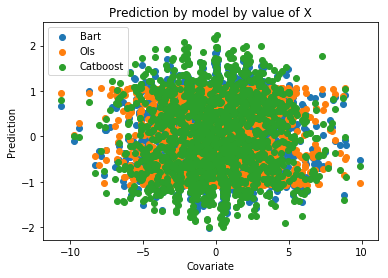

In [18]:
plt.scatter(X[:1500,3],predictions[0][1], label = "Bart")
plt.scatter(X[:1500,3],predictions[0][2], label = "Ols")
plt.scatter(X[:1500,3],predictions[0][0], label = "Catboost")
plt.ylabel("Prediction")
plt.xlabel("Covariate")
plt.title("Prediction by model by value of X")
plt.legend(loc = "best")

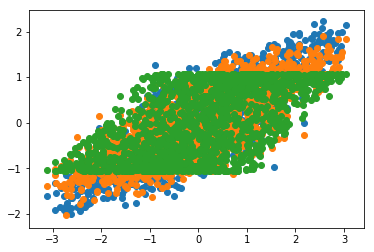

In [17]:
plt.scatter(y[:1500],predictions[0][0], label = "Catboost")
plt.scatter(y[:1500],predictions[0][1], label = "Catboost")
plt.scatter(y[:1500],predictions[0][2], label = "Catboost")

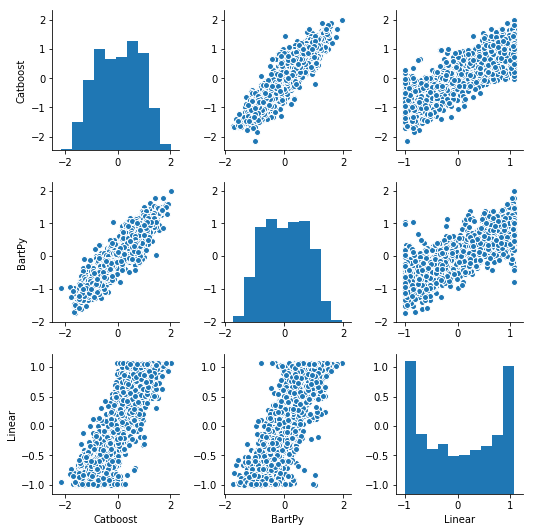

In [19]:
import seaborn as sns
p = pd.DataFrame(np.array(predictions[1]).T, columns = ["Catboost", "BartPy", "Linear"])
sns.pairplot(p)